In [1]:
import pandas as pd
import sqlite3
import re
import matplotlib.pyplot as plt
import numpy as np
import pickle
import string
import itertools

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS

from sklearn.model_selection import train_test_split, cross_val_predict

from sklearn.linear_model import SGDClassifier, LogisticRegressionCV
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.pipeline import Pipeline

from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
############# Helper functions #############

############################################
######### From the documentation ###########
############ CONFUSION MATRIX ##############
############################################

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

#######################################
##### top10keywords from pipeline #####
#######################################

def top10keys(pipe_model, classes):
    vectorizer = pipe_model.named_steps['vectorizer']
    clf = pipe_model.named_steps['clf']
    
    features_names = vectorizer.get_feature_names()
    features_names = np.asarray(features_names)
    
    print('Number of features: {} \n'.format(len(features_names)))
    
    try:
        if len(classes) > 2:
            for i, label in enumerate(classes):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print('%s: %s' % (label,', '.join(features_names[top10])))
        else:
            top10 = np.argsort(clf.coef_[0])[-10:] 
            print('Top 10 features found in %s:' % (classes[1]))
            print('%s' % (', '.join(features_names[top10])))
    except AttributeError:
        top10 = np.argsort(clf.feature_importances_)[-10:]
        print('Top 10 features found in %s:' % (classes[1]))
        print('%s' % (', '.join(features_names[top10])))

#######################################
### predict and print all the stuff ###
#######################################

def predict_and_win(classes_names):
    
    y_pred = pipe.predict(X_test) 
    
    # OR cross_val_predict(pipe, X, y, cv=3) to combine cros_val with prediction here but that would mean make_pipeline instead of pipeline
    
    print('Classification Report: \n')
    print(metrics.classification_report(y_test, y_pred))
    print('='*60)
    print('Accuracy: {}'.format(metrics.accuracy_score(y_test,y_pred)))
    print('='*60)
    plot_confusion_matrix(metrics.confusion_matrix(y_test, y_pred), classes=classes_names, title='Confusion matrix')


# Project 4: NLP, NLP, NLP

We will be doing all classification models and attempt to kill two ~~birds~~ questions with one ~~stone~~ classification model - which is Section 1 and the bonus section. However, I would require the answers to Section 2 before I am able to do Section 1 So, I won't be going through the project in the same order as the README file. Sorry...and yes, there's not a lot of cross validation here. :P except for Logistic Regression here. Mainly because... I technically don't have labels, so I have engineered my own labels most of the time.

## Bringing in my tables from SQL

In [3]:
connection = sqlite3.connect('job_scraped.db.sqlite')

In [4]:
sql_query = '''
SELECT *
FROM jobs
'''

In [5]:
df = pd.read_sql(sql_query, con=connection)

In [6]:
df.head()

,description,id,title
0,Dubbed “The Most Innovative Streaming Video Se...,2abc0718a6987824,Data Analyst
1,Title: Data Analyst\n\nRole:\n\nReporting to t...,c95dd846041ca1c5,Data Analyst
2,What is the job ?\n\n\nThe role will involve m...,59df81c8a00dc826,Junior Data Analyst
3,Data Analyst - (180000E0)\nDescription\n\nUnde...,6d9971d09cb788a6,Data Analyst
4,Your Responsibilities :\n\nThe Role\n\n\nIn th...,b4c4860763098784,Data Insights Analyst


In [7]:
# Check for duplicates
df['id'].duplicated(keep='first').sum()

0

In [8]:
# Check for data entry jobs
df[df['title'].str.contains('Data Entry')]

,description,id,title


In [9]:
# Check for Internships
df[df['title'].str.contains('Internship')]

,description,id,title
17,"Expedia\n\nIf you are seeking a collaborative,...",b4360fcd5896614c,Internship – Singapore – Data Growth Analyst I...
19,In your new role you will:\nAssist analytics t...,7ea2500e814e660b,Internship - Data Analyst
169,Job Summary\n\nJob Title: Summer Internship 20...,a4be9d6531a5fd98,Summer Internship 2018
258,About Us:\nGE is the world's Digital Industria...,bf54a0408db5e412,Internship -Business Analyst- Healthcare (Jul ...
478,About Us:\nGE is the world's Digital Industria...,14533e4fd58270cf,Internship - Service Operations
497,About Us:\nGE is the world’s Digital Industria...,055cb0d9d8aa982c,GE Aviation Internship
521,In your role you will:\nBe involved in key pro...,207475703e8d5f08,Internship - Test Automation
534,In your new role you will\nBe involved in lots...,67081fd9c763ba0f,Internship - Product Test Engineering (Automat...
902,About the Role\n\n\nInformation Technology at ...,86b371ee515b345c,Artificial Intelligent Bot Engineer - Internship
1101,In your new role you will:\nStudy and assess c...,93c36bce0027be71,Internship - R&D Big Data Analysis using AI/ML


Hurray! No duplicates (!) and no data entry jobs. There are some internships, but let's leave them in and see what happens.

## 1) Data Scientists versus others
What components of a job posting distinguish data scientists from other data jobs?

### Data Scientist vs Data Analyst vs Data Engineer

In [10]:
# Extracting all jobs with "Data Science" in the title

only_ds = df[df['title'].isin(['Data Scientist','Junior Data Scientist','Senior Data Scientist'])].copy()
only_ds['label'] = 'DS'

In [11]:
only_da = df[df['title'].isin(['Data Analyst','Junior Data Analyst','Senior Data Analyst'])].copy()
only_da['label'] = 'DA'

In [12]:
only_de = df[df['title'].isin(['Data Engineer','Junior Data Engineer','Senior Data Engineer'])].copy()
only_de['label'] = 'DE'

In [13]:
ds_vs_others = pd.concat([only_ds,only_da,only_de], ignore_index=True)

In [14]:
ds_vs_others.head()

,description,id,title,label
0,PURPOSE OF THE ROLE\nThis role of a data scien...,21a0e80107ccbbc3,Data Scientist,DS
1,Work cross-functionally with business managers...,95a6064e4ea39071,Data Scientist,DS
2,Serve as primary source of data insights suppo...,dc9137eaa6d7040a,Data Scientist,DS
3,"Big data, artificial intelligence and advanced...",8401de1b34480359,Data Scientist,DS
4,As the innovation leader in the logistics indu...,eb0952cd8bad461b,Data Scientist,DS


In [15]:
ds_vs_others['label'].value_counts()

DS    33
DE    25
DA    21
Name: label, dtype: int64

In [16]:
print('Baseline: {}'.format(1.0-(float(33)/float(33+25+21))))

Baseline: 0.582278481013


WOOT! I have a balanced dataset :) albeit small.... but let's see if we can infer anything from it using NLP.

### Simple cleaning, no stemming or lemmitization because it is so small (rows = 60+).

In [17]:
# Removing punctuation, numbers and lowercase all
ds_vs_others['clean'] = ds_vs_others['description'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x).lower())

In [18]:
ds_vs_others.head()

,description,id,title,label,clean
0,PURPOSE OF THE ROLE\nThis role of a data scien...,21a0e80107ccbbc3,Data Scientist,DS,purpose of the role this role of a data scient...
1,Work cross-functionally with business managers...,95a6064e4ea39071,Data Scientist,DS,work cross functionally with business managers...
2,Serve as primary source of data insights suppo...,dc9137eaa6d7040a,Data Scientist,DS,serve as primary source of data insights suppo...
3,"Big data, artificial intelligence and advanced...",8401de1b34480359,Data Scientist,DS,big data artificial intelligence and advanced...
4,As the innovation leader in the logistics indu...,eb0952cd8bad461b,Data Scientist,DS,as the innovation leader in the logistics indu...


In [19]:
X = ds_vs_others['clean']
y = ds_vs_others['label']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
pipe = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('clf', LogisticRegressionCV(cv=3, random_state=42))
])

model = pipe.fit(X_train, y_train)

In [22]:
top10keys(model, classes=['DA', 'DE', 'DS'])

Number of features: 2696 

DA: analysis, skills, strong, and, reports, business, clients, requirements, reporting, analyst
DE: skill, is, pipelines, number, infrastructure, building, you, of, data, engineer
DS: problems, scientist, in, business, research, analytics, science, models, machine, learning


Classification Report: 

             precision    recall  f1-score   support

         DA       0.67      0.67      0.67         6
         DE       1.00      0.57      0.73         7
         DS       0.71      0.91      0.80        11

avg / total       0.79      0.75      0.75        24

Accuracy: 0.75
Confusion matrix, without normalization
[[ 4  0  2]
 [ 1  4  2]
 [ 1  0 10]]


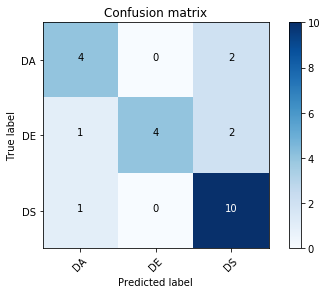

In [23]:
predict_and_win(['DA', 'DE', 'DS'])

Not bad... DEs are not misclassified at all or much.

In [24]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english', ngram_range=(1,2))),
    ('clf', SGDClassifier(random_state=42))
])

model = pipe.fit(X_train, y_train)

top10keys(model, classes=['DA', 'DE', 'DS'])

Number of features: 11268 

DA: planning, microsoft, reports, audit, clients, sales, customer, reporting, data analyst, analyst
DE: end, data, data warehousing, infrastructure, skill, warehousing, aws, pipelines, data engineer, engineer
DS: stakeholders, data scientist, scientist, data analytics, learning, machine learning, machine, models, research, analytics


/usr/local/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Classification Report: 

             precision    recall  f1-score   support

         DA       0.60      0.50      0.55         6
         DE       1.00      0.71      0.83         7
         DS       0.71      0.91      0.80        11

avg / total       0.77      0.75      0.75        24

Accuracy: 0.75
Confusion matrix, without normalization
[[ 3  0  3]
 [ 1  5  1]
 [ 1  0 10]]


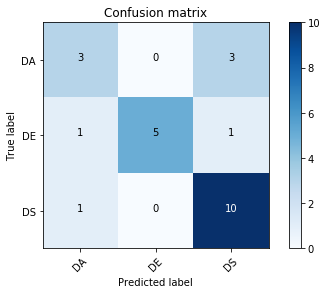

In [25]:
predict_and_win(['DA', 'DE', 'DS'])

I felt that company names in the job description would be a factor. Removing them might make my improve my model. At this point, I went back and scraped for company names. I just needed enough to add as stop words.

In [26]:
# Load in the pickled list of company names
with open('company_names.p','rb') as f:
    company_names = pickle.load(f)

In [27]:
# Remove duplicates
company_names = list(set(company_names))

# Turn into dataframe for easy removal of punctuation and lowercasing
company_df = pd.DataFrame({'companies': company_names})

In [28]:
company_names = company_df['companies'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x).lower().split()).tolist()
company_names = [y for x in company_names for y in x]

In [29]:
# Remove duplicates
company_names = list(set(company_names))

# Add 'jll' because it is a real estate company and microsoft because .... microsoft
company_names.extend(['jll','microsoft'])

In [30]:
# Add to the stopwords list
stop_words1 = ENGLISH_STOP_WORDS.union(company_names)

In [31]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stop_words1, ngram_range=(1,2))),
    ('clf', SGDClassifier(random_state=42))
])

model = pipe.fit(X_train, y_train)

top10keys(model, classes=['DA', 'DE', 'DS'])

Number of features: 10478 

DA: report, great work, ability, audit, planning, reporting, clients, sales, data analyst, analyst
DE: infrastructure, engineering, end, data warehousing, skill, aws, warehousing, pipelines, data engineer, engineer
DS: fraud, algorithms, machine learning, stakeholders, learning, data scientist, scientist, machine, models, research


Classification Report: 

             precision    recall  f1-score   support

         DA       0.80      0.67      0.73         6
         DE       1.00      0.86      0.92         7
         DS       0.77      0.91      0.83        11

avg / total       0.84      0.83      0.83        24

Accuracy: 0.833333333333
Confusion matrix, without normalization
[[ 4  0  2]
 [ 0  6  1]
 [ 1  0 10]]


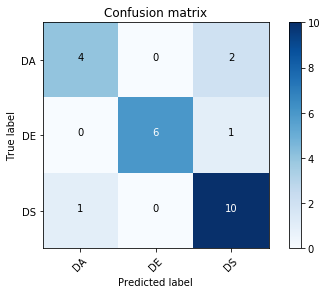

In [32]:
predict_and_win(['DA', 'DE', 'DS'])

In [33]:
# Let's do this with the ensemble method of the boosting family: GradientBoostingClassifier which is quite similar to the SGDClassifier 

pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stop_words1, ngram_range=(1,2))),
    ('clf', GradientBoostingClassifier(random_state=42))
])

model = pipe.fit(X_train, y_train)

Classification Report: 

             precision    recall  f1-score   support

         DA       1.00      0.67      0.80         6
         DE       1.00      1.00      1.00         7
         DS       0.85      1.00      0.92        11

avg / total       0.93      0.92      0.91        24

Accuracy: 0.916666666667
Confusion matrix, without normalization
[[ 4  0  2]
 [ 0  7  0]
 [ 0  0 11]]


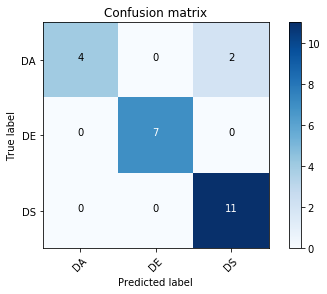

In [34]:
predict_and_win(['DA', 'DE', 'DS'])

### Conclusion

Removing company names (as much as possible) resulted in more mis-classifications of Data Analysts as Data Scientist, but less for the other way round. Without company names in the mix, the job description are close enough that there's a higher chance of mis-classification. This leads me to the following:

1. Some companies posts Data Scientists job titles but the job descriptions reads closer to a Data Analyst title.
2. Because I added Junior Data Scientists in the Data Scientist pool, perhaps that caused the mix of job description as Jr. Data Scientists tend to be Data Analysts.
3. Data Analyst did have the lowerest number of samples, so not too surprised that it wasn't able to catch them all. 
4. One can argue that Data Analysts and Data Scientist are in the same cluster as each other, as compared to Data Engineers. Throughout all iterations, DEs were well classified and accurately so, with one wrong one (each)

**Lesson:** It is possible to derive some insights from a small dataset, it is just very important to clean the data as much as possible and be mindful of the top10 words in both categories (don't remove too much and/or don't remove too little).

**Choosing models:** A combination of simple models, or a simple model is better than a single complicated model. LogisticRegression did quite well on its own, unoptimized. GradientBoostingClassifier, which is a combination of weaker models also did very well. SGDClassifier needed a lot of work (added more stop words) to even meet LogisticRegression's first attempt.



## 2) What features are important for distinguishing junior vs. senior positions?

Salary numbers: https://www.techinasia.com/data-scientist-salaries-singapore-revealed and https://www.payscale.com/ 

In [35]:
only_jr = df[df['title'].str.contains('Junior|Jr|Associate|Assoc|Executive|Exec|Entry')].copy()
only_jr['label'] = 'Jr'

In [36]:
only_sr = df[df['title'].str.contains('Senior|Sr')].copy()
only_sr['label'] = 'Sr'

In [37]:
jr_vs_sr = pd.concat([only_jr,only_sr], ignore_index=True)

In [38]:
jr_vs_sr['label'].value_counts()

Sr    196
Jr    103
Name: label, dtype: int64

In [39]:
print('Baseline: {}'.format(float(196)/float(103+196)))

Baseline: 0.655518394649


In [40]:
jr_vs_sr.head()

,description,id,title,label
0,What is the job ?\n\n\nThe role will involve m...,59df81c8a00dc826,Junior Data Analyst,Jr
1,About the Business Analyst position\n\nWe are ...,97326f6a06a4d7dc,Business Analyst/Junior PM,Jr
2,Contribute to the Revenue Optimization departm...,b3410677f90d5db2,"Associate Analyst/Analyst, Analytics",Jr
3,BlackRock helps investors build better financi...,d40e45e6c5c014ad,"Data Implementation, Associate",Jr
4,The Company\nWillis Towers Watson is a leading...,ea2518a4ebd725fd,"Analyst - Executive Compensation, Singapore",Jr


In [41]:
jr_vs_sr['clean'] = jr_vs_sr['description'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x).lower())

In [42]:
X = jr_vs_sr['clean']
y = jr_vs_sr['label']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [44]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegressionCV(cv=3, random_state=42, class_weight='balanced'))
])

model = pipe.fit(X_train, y_train)

In [45]:
top10keys(model, ['Junior','Senior'])

Number of features: 5862 

Top 10 features found in Senior:
technical, lead, architecture, product, oracle, science, project, senior, experience, business


Classification Report: 

             precision    recall  f1-score   support

         Jr       0.73      0.54      0.62        35
         Sr       0.75      0.87      0.81        55

avg / total       0.74      0.74      0.74        90

Accuracy: 0.744444444444
Confusion matrix, without normalization
[[19 16]
 [ 7 48]]


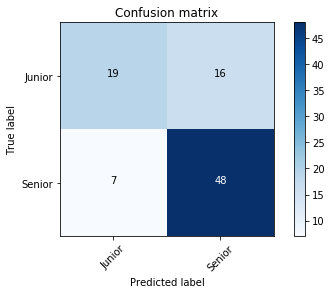

In [46]:
predict_and_win(['Junior','Senior'])

In [47]:
# Add 'responsibilities','requirements','relevant','years' and others to stop words
stop_words2 = stop_words1.union(['oracle','axa','edb','responsibilities','requirements','relevant','years','science','experience','advantage','phd','senior'])

In [48]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stop_words2, ngram_range=(2,2), max_df=0.8)),
    ('clf', SGDClassifier(random_state=42, class_weight='balanced'))
])

model = pipe.fit(X_train, y_train)

In [49]:
top10keys(model, ['Junior','Senior'])

Number of features: 32562 

Top 10 features found in Senior:
possess strong, roles utilizing, business analyst, sql server, degree computer, business problems, business process, ms sql, working knowledge, best practices


Classification Report: 

             precision    recall  f1-score   support

         Jr       0.63      0.63      0.63        35
         Sr       0.76      0.76      0.76        55

avg / total       0.71      0.71      0.71        90

Accuracy: 0.711111111111
Confusion matrix, without normalization
[[22 13]
 [13 42]]


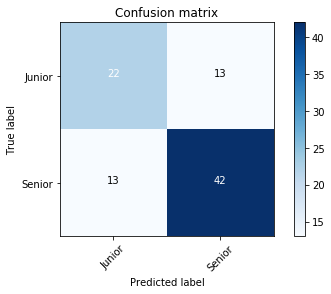

In [50]:
predict_and_win(['Junior','Senior'])

In [51]:
# Ensemble method here:

pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stop_words2, ngram_range=(2,2), max_df=0.8)),
    ('clf', GradientBoostingClassifier(random_state=42))
])

model = pipe.fit(X_train, y_train)

In [52]:
top10keys(model, ['Junior','Senior'])

Number of features: 32562 

Top 10 features found in Senior:
operations team, welcome apply, corporate institutional, successful applicant, competitive job, ms office, looking suitable, data collection, oral written, interpersonal skills


Classification Report: 

             precision    recall  f1-score   support

         Jr       0.60      0.51      0.55        35
         Sr       0.72      0.78      0.75        55

avg / total       0.67      0.68      0.67        90

Accuracy: 0.677777777778
Confusion matrix, without normalization
[[18 17]
 [12 43]]


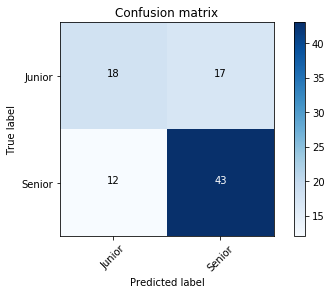

In [53]:
predict_and_win(['Junior','Senior'])

### Conclusion

One can argue that most of today's Junior roles in Data Science share a lot of key terms with Senior roles (models overall did better once 'PhD' was removed). `max_df` had to be set at a precise 0.60 in order to produce a better predictions. This means that it removed all terms that appeared more than 60% in all documents. There are two reasons to this:
1. Job adverts tend to sound kinda the same anyway.
2. A Senior role can be defined as someone with a Junior role AND 40% more. Pinpoining the terms down to these few, would need a lot more tuning.

I am quite happy with 0.70+ accuracy score here as I don't want it to overfit on this and it is an imbalanced dataset to start with. LogisticRegression didn't do so well this time, but could be due to the imbalanced classes.


### For Boss

Junior and Senior a 'good' model is not really what the boss wants. Since he/she would like to inform a candidate that they would receive a lower salary that they would, in reality, get. With this, this means that we would need to find a model that would optimise for lower False Negatives (lower Senior predictions).

In [54]:
# Boss, you would use this model instead

pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stop_words2, ngram_range=(1,2))),
    ('clf', SGDClassifier(random_state=42, class_weight='balanced'))
])

model = pipe.fit(X_train, y_train)
top10keys(model, ['Junior','Senior'])

Number of features: 38241 

Top 10 features found in Senior:
ensure, insights, leadership, best, ai, security, problems, product, lead, business


Classification Report: 

             precision    recall  f1-score   support

         Jr       0.64      0.77      0.70        35
         Sr       0.83      0.73      0.78        55

avg / total       0.76      0.74      0.75        90

Accuracy: 0.744444444444
Confusion matrix, without normalization
[[27  8]
 [15 40]]


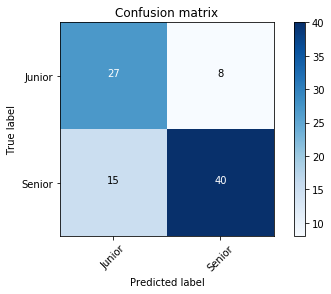

In [55]:
predict_and_win(['Junior','Senior'])

Essentially, this model is not a good classification model. In fact, it is quite a bad one with the high rate of Junior-but-actually-Senior predictions. But since that is what we will use to manage the expectation of the candidate, "This is a junior role so it is only so-so in salary."

# 3) Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

In [56]:
df.head()

,description,id,title
0,Dubbed “The Most Innovative Streaming Video Se...,2abc0718a6987824,Data Analyst
1,Title: Data Analyst\n\nRole:\n\nReporting to t...,c95dd846041ca1c5,Data Analyst
2,What is the job ?\n\n\nThe role will involve m...,59df81c8a00dc826,Junior Data Analyst
3,Data Analyst - (180000E0)\nDescription\n\nUnde...,6d9971d09cb788a6,Data Analyst
4,Your Responsibilities :\n\nThe Role\n\n\nIn th...,b4c4860763098784,Data Insights Analyst


In [57]:
df[df['description'].str.contains('industry')].count()

description    453
id             453
title          453
dtype: int64

I am not going to kill myself and the model trying to sieve through finance vs banking. So I will choose two opposite industries that also _happens_ to have a balanced class count: Manufacturing and Finance.

In [58]:
only_fin = df[df['description'].str.contains('finance')].copy()
only_fin['label'] = 'Finance'

In [59]:
only_mfg = df[df['description'].str.contains('manufacturing')].copy()
only_mfg['label'] = 'Manufacturing'

In [60]:
industry = pd.concat([only_fin,only_mfg], ignore_index=True)

# Dropping ID because we don't need it anymore, but we want Title later :D
industry.drop(columns=['id'], inplace=True)

In [61]:
industry.head()

,description,title,label
0,Your Responsibilities :\n\nThe Role\n\n\nIn th...,Data Insights Analyst,Finance
1,"Risk Data Analyst, Group Portfolio Analytics &...","Risk Data Analyst, Group Portfolio Analytics &...",Finance
2,Businesses that partner with Google come in al...,"Strategy and Insights Analyst, Agency Business...",Finance
3,The Analyst/Developer role is a delivery focus...,Front Office Analyst,Finance
4,Business Analyst (Corporate Banking) - (180000...,Business Analyst (Corporate Banking),Finance


In [62]:
industry['label'].value_counts()

Manufacturing    93
Finance          92
Name: label, dtype: int64

In [63]:
industry['clean'] = industry['description'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x).lower())

In [64]:
X = industry['clean']
y = industry['label']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

In [66]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegressionCV(cv=3, random_state=42))
])

model = pipe.fit(X_train, y_train)

In [67]:
top10keys(model, ['Finance','Manufacturing'])

Number of features: 3122 

Top 10 features found in Manufacturing:
formulation, software, sciex, procurement, hana, equipment, process, engineering, technical, manufacturing


Classification Report: 

               precision    recall  f1-score   support

      Finance       0.90      0.97      0.93        65
Manufacturing       0.97      0.89      0.93        65

  avg / total       0.93      0.93      0.93       130

Accuracy: 0.930769230769
Confusion matrix, without normalization
[[63  2]
 [ 7 58]]


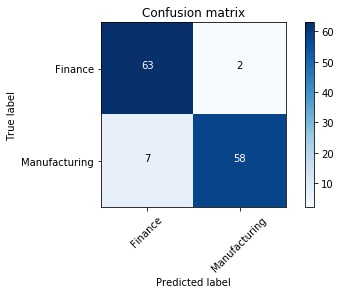

In [68]:
predict_and_win(['Finance','Manufacturing'])

I fear something might be amiss. 

In [69]:
# Add 'manufacturing' and 'finance' to stop words
stop_words3 = stop_words1.union(['manufacturing','finance'])

In [70]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stop_words3)),
    ('clf', LogisticRegressionCV(cv=3, random_state=42))
])

model = pipe.fit(X_train, y_train)

In [71]:
top10keys(model, ['Finance','Manufacturing'])

Number of features: 3012 

Top 10 features found in Manufacturing:
supplier, production, status, procurement, formulation, hana, equipment, process, engineering, technical


Classification Report: 

               precision    recall  f1-score   support

      Finance       0.82      0.97      0.89        65
Manufacturing       0.96      0.78      0.86        65

  avg / total       0.89      0.88      0.88       130

Accuracy: 0.876923076923
Confusion matrix, without normalization
[[63  2]
 [14 51]]


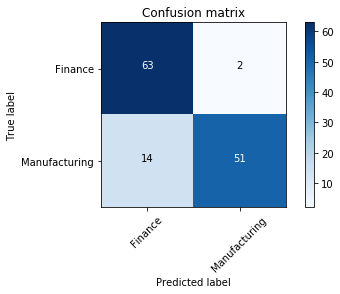

In [72]:
predict_and_win(['Finance','Manufacturing'])

In [73]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stop_words3, ngram_range=(1,4))),
    ('clf', SGDClassifier(random_state=42))
])

model = pipe.fit(X_train, y_train)

In [74]:
top10keys(model, ['Finance','Manufacturing'])

Number of features: 37574 

Top 10 features found in Manufacturing:
production, cell culture, chemistry, cell, chemical, formulation, equipment, process, engineering, technical


Classification Report: 

               precision    recall  f1-score   support

      Finance       0.88      0.97      0.92        65
Manufacturing       0.97      0.86      0.91        65

  avg / total       0.92      0.92      0.92       130

Accuracy: 0.915384615385
Confusion matrix, without normalization
[[63  2]
 [ 9 56]]


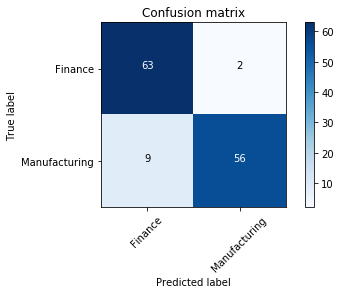

In [75]:
predict_and_win(['Finance','Manufacturing'])

In [76]:
# Let's see if our GradientBoostingClassifier can make it even better

pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stop_words3, ngram_range=(1,4))),
    ('clf', GradientBoostingClassifier(random_state=42))
])

model = pipe.fit(X_train, y_train)

In [77]:
top10keys(model, ['Finance','Manufacturing'])

Number of features: 37574 

Top 10 features found in Manufacturing:
background, mechanical, equipment, process, institutions, experience, qualifications, manages, operating, business


Classification Report: 

               precision    recall  f1-score   support

      Finance       0.64      0.77      0.70        65
Manufacturing       0.71      0.57      0.63        65

  avg / total       0.68      0.67      0.67       130

Accuracy: 0.669230769231
Confusion matrix, without normalization
[[50 15]
 [28 37]]


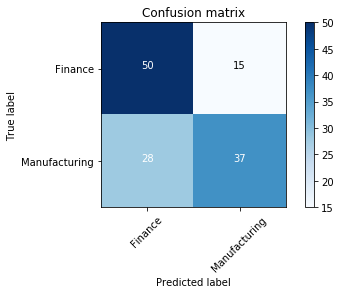

In [78]:
predict_and_win(['Finance','Manufacturing'])

### Conclusion

KISS wins the day. Keep it Simple, Stupid. LogisticRegression performed the best.

# 4) Salary Prediction

My original dataset did not have any salary column. And it also contained search results that are not entirely related. I plan to solve it this way:
1. Predict if the role is either DS/DA, DE or DArch, or others. 
2. Predict if the role is either Jr. or Sr.
3. Sort accordingly.

I wonder if I can do some clustering...

https://stackoverflow.com/questions/8897593/similarity-between-two-text-documents and http://brandonrose.org/clustering

In [79]:
ds_vs_others.head()

,description,id,title,label,clean
0,PURPOSE OF THE ROLE\nThis role of a data scien...,21a0e80107ccbbc3,Data Scientist,DS,purpose of the role this role of a data scient...
1,Work cross-functionally with business managers...,95a6064e4ea39071,Data Scientist,DS,work cross functionally with business managers...
2,Serve as primary source of data insights suppo...,dc9137eaa6d7040a,Data Scientist,DS,serve as primary source of data insights suppo...
3,"Big data, artificial intelligence and advanced...",8401de1b34480359,Data Scientist,DS,big data artificial intelligence and advanced...
4,As the innovation leader in the logistics indu...,eb0952cd8bad461b,Data Scientist,DS,as the innovation leader in the logistics indu...


In [80]:
jr_vs_sr.head()

,description,id,title,label,clean
0,What is the job ?\n\n\nThe role will involve m...,59df81c8a00dc826,Junior Data Analyst,Jr,what is the job the role will involve main...
1,About the Business Analyst position\n\nWe are ...,97326f6a06a4d7dc,Business Analyst/Junior PM,Jr,about the business analyst position we are lo...
2,Contribute to the Revenue Optimization departm...,b3410677f90d5db2,"Associate Analyst/Analyst, Analytics",Jr,contribute to the revenue optimization departm...
3,BlackRock helps investors build better financi...,d40e45e6c5c014ad,"Data Implementation, Associate",Jr,blackrock helps investors build better financi...
4,The Company\nWillis Towers Watson is a leading...,ea2518a4ebd725fd,"Analyst - Executive Compensation, Singapore",Jr,the company willis towers watson is a leading ...


In [81]:
ds_vs_others.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 5 columns):
description    79 non-null object
id             79 non-null object
title          79 non-null object
label          79 non-null object
clean          79 non-null object
dtypes: object(5)
memory usage: 3.2+ KB


In [82]:
jr_vs_sr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 5 columns):
description    299 non-null object
id             299 non-null object
title          299 non-null object
label          299 non-null object
clean          299 non-null object
dtypes: object(5)
memory usage: 11.8+ KB


In total I have 79 data points to train my first randomforest classifier. I then have 299 to classify senior vs junior. Bearing in mind that there might be overlaps in these two datasets even, I will assume there aren't any, and this means that I will be training on 79+299 = 378 data points. Which leaves me about 1000 rows to test on. 

In [83]:
# Remove all those ids not in either jr_vs_sr or ds_vs_others tables

Xsalary_test = df[~df['id'].isin(ds_vs_others['id'])].copy()
Xsalary_test = df[~df['id'].isin(jr_vs_sr['id'])].copy()

In [84]:
Xsalary_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1086 entries, 0 to 1372
Data columns (total 3 columns):
description    1086 non-null object
id             1086 non-null object
title          1086 non-null object
dtypes: object(3)
memory usage: 33.9+ KB


In [85]:
Xsalary_test.head()

,description,id,title
0,Dubbed “The Most Innovative Streaming Video Se...,2abc0718a6987824,Data Analyst
1,Title: Data Analyst\n\nRole:\n\nReporting to t...,c95dd846041ca1c5,Data Analyst
3,Data Analyst - (180000E0)\nDescription\n\nUnde...,6d9971d09cb788a6,Data Analyst
4,Your Responsibilities :\n\nThe Role\n\n\nIn th...,b4c4860763098784,Data Insights Analyst
5,Mastercard is continuing our growth momentum i...,4fa8672c4820336f,Strategy and Operations Analyst


In [86]:
Xsalary_test['clean'] = Xsalary_test['description'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x).lower())

In [87]:
Xsalary_test.head()

,description,id,title,clean
0,Dubbed “The Most Innovative Streaming Video Se...,2abc0718a6987824,Data Analyst,dubbed the most innovative streaming video se...
1,Title: Data Analyst\n\nRole:\n\nReporting to t...,c95dd846041ca1c5,Data Analyst,title data analyst role reporting to the d...
3,Data Analyst - (180000E0)\nDescription\n\nUnde...,6d9971d09cb788a6,Data Analyst,data analyst e description underst...
4,Your Responsibilities :\n\nThe Role\n\n\nIn th...,b4c4860763098784,Data Insights Analyst,your responsibilities the role in this ne...
5,Mastercard is continuing our growth momentum i...,4fa8672c4820336f,Strategy and Operations Analyst,mastercard is continuing our growth momentum i...


In [88]:
X_ds = ds_vs_others['clean']
y_ds = ds_vs_others['label']

X_sr = jr_vs_sr['clean']
y_sr = jr_vs_sr['label']

In [89]:
# Bring in the best model for DS vs others.
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stop_words1, ngram_range=(1,2))),
    ('clf', GradientBoostingClassifier(random_state=42))
])

model = pipe.fit(X_ds, y_ds)

In [90]:
ds_pred = model.predict(Xsalary_test['clean'])
Xsalary_test['is_DS'] = ds_pred

In [91]:
Xsalary_test.head()

,description,id,title,clean,is_DS
0,Dubbed “The Most Innovative Streaming Video Se...,2abc0718a6987824,Data Analyst,dubbed the most innovative streaming video se...,DA
1,Title: Data Analyst\n\nRole:\n\nReporting to t...,c95dd846041ca1c5,Data Analyst,title data analyst role reporting to the d...,DA
3,Data Analyst - (180000E0)\nDescription\n\nUnde...,6d9971d09cb788a6,Data Analyst,data analyst e description underst...,DA
4,Your Responsibilities :\n\nThe Role\n\n\nIn th...,b4c4860763098784,Data Insights Analyst,your responsibilities the role in this ne...,DS
5,Mastercard is continuing our growth momentum i...,4fa8672c4820336f,Strategy and Operations Analyst,mastercard is continuing our growth momentum i...,DA


In [92]:
# Best model for Jr vs Sr

pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stop_words2, ngram_range=(1,2), max_df=0.6)),
    ('clf', GradientBoostingClassifier(random_state=42))
])

model = pipe.fit(X_sr, y_sr)

In [93]:
sr_pred = model.predict(Xsalary_test['clean'])
Xsalary_test['is_Sr'] = sr_pred

In [94]:
Xsalary_test.head()

,description,id,title,clean,is_DS,is_Sr
0,Dubbed “The Most Innovative Streaming Video Se...,2abc0718a6987824,Data Analyst,dubbed the most innovative streaming video se...,DA,Jr
1,Title: Data Analyst\n\nRole:\n\nReporting to t...,c95dd846041ca1c5,Data Analyst,title data analyst role reporting to the d...,DA,Sr
3,Data Analyst - (180000E0)\nDescription\n\nUnde...,6d9971d09cb788a6,Data Analyst,data analyst e description underst...,DA,Sr
4,Your Responsibilities :\n\nThe Role\n\n\nIn th...,b4c4860763098784,Data Insights Analyst,your responsibilities the role in this ne...,DS,Jr
5,Mastercard is continuing our growth momentum i...,4fa8672c4820336f,Strategy and Operations Analyst,mastercard is continuing our growth momentum i...,DA,Sr


In [95]:
Xsalary_test['is_DS'].value_counts()

DA    744
DS    246
DE     96
Name: is_DS, dtype: int64

In [96]:
Xsalary_test['is_Sr'].value_counts()

Sr    850
Jr    236
Name: is_Sr, dtype: int64

In [97]:
Xsalary_test[(Xsalary_test['is_DS']=='DE')]['is_Sr'].value_counts()

Sr    78
Jr    18
Name: is_Sr, dtype: int64

In [98]:
m1 = Xsalary_test['is_DS'] == 'DS'
m2 = Xsalary_test['is_DS'] == 'DA'
m3 = Xsalary_test['is_DS'] == 'DE'

m4 = Xsalary_test['is_Sr'] == 'Sr'
m5 = Xsalary_test['is_Sr'] == 'Jr'

In [99]:
Xsalary_test['salary'] = 0

In [100]:
Xsalary_test.loc[m1 & m4, 'salary'] = 136783 # Senior DS roles
Xsalary_test.loc[m1 & m5, 'salary'] = 59480 # Junior DS roles

Xsalary_test.loc[m2 & m4, 'salary'] = 59480 # Senior DA roles
Xsalary_test.loc[m2 & m5, 'salary'] = 77998 # Junior DA roles

Xsalary_test.loc[m3 & m4, 'salary'] = 100000 # Senior DE roles
Xsalary_test.loc[m3 & m5, 'salary'] = 60606 # Junior DE roles

In [101]:
Xsalary_test.head()

,description,id,title,clean,is_DS,is_Sr,salary
0,Dubbed “The Most Innovative Streaming Video Se...,2abc0718a6987824,Data Analyst,dubbed the most innovative streaming video se...,DA,Jr,77998
1,Title: Data Analyst\n\nRole:\n\nReporting to t...,c95dd846041ca1c5,Data Analyst,title data analyst role reporting to the d...,DA,Sr,59480
3,Data Analyst - (180000E0)\nDescription\n\nUnde...,6d9971d09cb788a6,Data Analyst,data analyst e description underst...,DA,Sr,59480
4,Your Responsibilities :\n\nThe Role\n\n\nIn th...,b4c4860763098784,Data Insights Analyst,your responsibilities the role in this ne...,DS,Jr,59480
5,Mastercard is continuing our growth momentum i...,4fa8672c4820336f,Strategy and Operations Analyst,mastercard is continuing our growth momentum i...,DA,Sr,59480


In [102]:
# Check out the smallest group: Junior DEs

Xsalary_test[(m3 & m5)]

,description,id,title,clean,is_DS,is_Sr,salary
33,Job Description:\nWork with business analysts ...,5d896e46d99cf956,Data Quality Developer,job description work with business analysts a...,DE,Jr,60606
160,About J.P. Morgan Chase & Co.\nJPMorgan Chase ...,e3f8cd00426f8d9e,Corporate - Reference Data Operations - Asset ...,about j p morgan chase co jpmorgan chase ...,DE,Jr,60606
182,General information\n\nEntity\nCrédit Agricole...,2518ec0a12e66466,Business Analyst cum Project Manager Referenti...,general information entity cr dit agricole ci...,DE,Jr,60606
185,General information\n\nEntity\nCrédit Agricole...,ade5e8a1f51719bf,Project Manager cum Business Analyst,general information entity cr dit agricole ci...,DE,Jr,60606
244,General information\n\nEntity\nCrédit Agricole...,fbbbd02a51eb1441,Trainee Officer - Risk and Permanent Control,general information entity cr dit agricole ci...,DE,Jr,60606
313,Implement state-of-the-art deep learning and m...,b949489fc780e20f,Deep Learning Scientist,implement state of the art deep learning and m...,DE,Jr,60606
387,JOB DESCRIPTION:\n\n\nAs a Manufacturing Centr...,3c00795c0798846a,BE Data and Systems Engineer,job description as a manufacturing central ...,DE,Jr,60606
450,Role Purpose\n\n\nThe role of the Data Enginee...,212f0cbcd29544f6,Data Engineer,role purpose the role of the data engineer i...,DE,Jr,60606
451,We are looking for a highly-energetic Data Pla...,af9ecb25d2444b68,Data Platform Engineer - Deep Learning,we are looking for a highly energetic data pla...,DE,Jr,60606
462,Sephora South East Asia seeks to hire a Lead D...,9af3295860a68dab,Lead Data Engineer,sephora south east asia seeks to hire a lead d...,DE,Jr,60606


Let's check out a potential mis-classification...

In [103]:
print(Xsalary_test.loc[462, 'description'])

Sephora South East Asia seeks to hire a Lead Data Engineer to lead the small, talented team which drives much of the innovation that underpins our market leading performance marketing, CRM, Onsite and Business intelligence activities. He or she will replace the incumbent who is returning to France to join the LVMH Digital Team. This is a critical hire for the company as the evolution of our omni-channel vision is dependent on driving data driven decision making throughout our business across both the retail and ecommerce channels.

If you are the right candidate, you will bring outstanding technical skills built on a strong academic foundation and honed in a company that prizes data driven decision making, excellent business acumen, and the ability to both understand business problems and to see solutions. You will be a creative engineer with a track record of building innovative tools that solve problems and are “future-proof”. This is a challenging role and to be successful you will 

In [104]:
Xsalary_test[(Xsalary_test['is_DS']=='DS')]['is_Sr'].value_counts()

Sr    189
Jr     57
Name: is_Sr, dtype: int64

In [105]:
Xsalary_test[(m1 & m5)].sample(5)

,description,id,title,clean,is_DS,is_Sr,salary
555,Lazada Internship Program for Tech Hub\nThe In...,f6fc50e8649d8837,"Intern, Performance Engineering",lazada internship program for tech hub the int...,DS,Jr,59480
1013,Job Description\nWe are hiring Product Support...,80aad0cc03895645,Product Support Engineer,job description we are hiring product support ...,DS,Jr,59480
173,Review and ensure integrity of data collection...,66b04d95d0ce8dcf,Business Intelligence Analyst - Singapore Full...,review and ensure integrity of data collection...,DS,Jr,59480
392,To work with research scientists/clinicians wi...,372b3bb88edff9d0,Mobile Apps Developer,to work with research scientists clinicians wi...,DS,Jr,59480
4,Your Responsibilities :\n\nThe Role\n\n\nIn th...,b4c4860763098784,Data Insights Analyst,your responsibilities the role in this ne...,DS,Jr,59480


In [106]:
print(Xsalary_test.loc[392, 'description'])

To work with research scientists/clinicians within the research programme and develop relevant mobile apps which will be used by research team and subjects in order to meet project objectives.
Duties & Responsibilities:
Develop functional mobile-based applications (both iOS and Android) based on usability
Good experience with Android SDK, Frameworks and tools to create mobile web
Working directly with research scientists and/or users to conceptualize, build and test mobile/web applications
Participate in ad hoc software projects and assignments as required
Debugging and optimization skills
Qualifications

Polytechnic specialist diploma in Mobile Apps development with some working experience in mobile iOS and Android development
Bachelor degree in software engineering, computer science or related discipline
Strong knowledge in native Ios and Android development using Objective-C/Swift and Java
Experience and knowledge of data structure and alogrithms
Strong analystical and problem-solvi

In [107]:
# I know there are internships in the titles. Let's look at those...

Xsalary_test[Xsalary_test['description'].str.contains('internship')].sample(5)

,description,id,title,clean,is_DS,is_Sr,salary
547,"ABOUT GOLDMAN SACHS\nThe Goldman Sachs Group, ...",9b53b8c164e8b086,2018 Full Time Campus Analyst - Engineering Di...,about goldman sachs the goldman sachs group i...,DA,Sr,59480
244,General information\n\nEntity\nCrédit Agricole...,fbbbd02a51eb1441,Trainee Officer - Risk and Permanent Control,general information entity cr dit agricole ci...,DE,Jr,60606
1336,Roles & Responsibilities\ntalentguru (www.tale...,ced347f0dee7ac39,information technology,roles responsibilities talentguru www talen...,DA,Jr,77998
340,Job responsibilities\nProvide analytical suppo...,47c51f51705e7fbf,Analytical Chemist,job responsibilities provide analytical suppor...,DS,Sr,136783
169,Job Summary\n\nJob Title: Summer Internship 20...,a4be9d6531a5fd98,Summer Internship 2018,job summary job title summer internship ...,DA,Sr,59480


In [108]:
print(Xsalary_test.loc[541, 'description'])

About Us:
GE is the world's Digital Industrial Company, transforming industry with software-defined machines and solutions that are connected, responsive and predictive. Through our people, leadership development, services, technology and scale, GE delivers better outcomes for global customers by speaking the language of industry.

Role Summary:
GE’s internships offer a unique opportunity to gain hands-on experience through challenging projects, learn from some of the brightest and most innovative minds in the business and network with a variety of talented professionals.

Essential Responsibilities:
The interns will support our leaders in their projects and day to day work. Interns will have project(s) assigned to be completed within the given time frame and content.
We will be hiring across our various businesses in Singapore & for various functions including:

Functions:

Production Planning & Analytics

GE Businesses:
Aviation

Project:
Working together with Business Analytics and 

HAHAHAHAHA.....

Another one...

In [109]:
print(Xsalary_test.loc[902, 'description'])

About the Role


Information Technology at Seagate Singapore International Headquarters Pte Ltd has a unique opportunity for a summer intern to develop an intelligent bot to help the Manufacturing System Users Community.


The goal of this project is to develop a bot using artificial intelligence (AI) and language understanding Intelligent service (LUIS) along with Google Home and Amazon Alexa (and other digital agents) to help the Seagate community find the information they need quickly and easily. This will enable individuals to quickly find information regarding commonly asked questions or issues without having to dig through a web site, submit a support ticket or try to find the right person.


Creative contributors apply! You will be work closely with the Global Operation IT development team. Skills acquired: team collaboration, developing and deploying to the cloud, working with version control, exposed to an agile environment for project management, Amazan/Google chatbot framewo

### LOL hashtag internship

After a quick consultation with my team mates for the presentation, the internships reads more like a senior role and therefore it is not **that** hard to understand why even the model classified it as a "Senior" role. I would probably remove them at the start since this was the case, but it is a good idea on how the model was able to perform. 